## Sequential A/B Testing
- 此 Notebook 將介紹 Sequential A/B Testing
- 主要參考資料是 Evan Miller 的文章（[連結](https://www.evanmiller.org/sequential-ab-testing.html)）


In [1]:
#@title Import Packages
import numpy as np
import pandas as pd
from scipy import stats
import numpy as np
import math
from plotnine import *

## 將會與標準假設檢定的固定樣本方法比較所需樣本數

In [2]:
#@title Calculate Sample Size for 'Fixed-sample-size-method'
# ref: https://stats.stackexchange.com/questions/178568/calculate-sample-size-based-on-conversion-rate-minimum-detectable-effect-stati
def get_sample_size(base_rate, absolute_diff, alpha=0.05, beta=0.2, if_one_tail=True):
    p0 = base_rate
    p1 = base_rate + absolute_diff
    result = np.power(stats.norm.ppf(1 - alpha / (1.0 if if_one_tail else 2.)) + stats.norm.ppf(1 - beta), 2)
    result *= (p0 * (1 - p0)) + (p1 * (1 - p1))
    result = result / np.power(absolute_diff, 2)
    return math.ceil(result)

## Sequential A/B Testing 所需樣本數可以查表取得

In [3]:
#@title Sample Size Reference Table for Sequential A/B Testing
# ref: https://www.evanmiller.org/ab-testing/sequential.html
seq_size_table = pd.DataFrame({
    'sig': [0.05]*5,
    'power': [0.8]*5,
    'min_relative_effect': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_total_success': [2922, 808, 391, 243, 170],
    'n_success_ahead': [106, 56, 39, 31, 26],
})
seq_size_table

,sig,power,min_relative_effect,n_total_success,n_success_ahead
0,0.05,0.8,0.1,2922,106
1,0.05,0.8,0.2,808,56
2,0.05,0.8,0.3,391,39
3,0.05,0.8,0.4,243,31
4,0.05,0.8,0.5,170,26


## Simple Sequential A/B Testing 規則（單尾檢定）
1. 決定好你對實驗假設的顯著力、檢定力、以及期望的轉換率差異量之後，使用 [計算機](https://www.evanmiller.org/ab-testing/sequential.html) 或者查表，選出**轉換成功**樣本數大小 N
2. 開始 A/B Testing
3. 持續觀測實驗組（B 組）的轉換成功數量 $T$、以及控制組（A 組）轉換成功數量 $C$
4. 如果 $T - C$ 超過 $2\sqrt{N}$，宣告實驗組較好，結束實驗
5. 如果第 4 點不成立，且 $T + C$ 累積到超過 $N$，無法宣告任一方較好，結束實驗

In [4]:
#@title Sequential A/B Testing
def seq_ab_testing(base_rate=0.01, 
          true_relative_lift_effect=0, 
          n_total_success=808, 
          n_success_ahead=56):
    step_size = 50
    sample_size_per_group = 0
    n_success_a, n_success_b = 0, 0
    while True:
        sample_size_per_group += step_size
        n_success_a += np.random.binomial(n=step_size, p=base_rate)
        n_success_b += np.random.binomial(n=step_size, p=base_rate*(1+true_relative_lift_effect))
        if (n_success_b - n_success_a) >= n_success_ahead:
            return {'sample_size_per_group': sample_size_per_group, 'n_success_a': n_success_a, 'n_success_b': n_success_b, 'if_b_win': True}
        elif (n_success_a + n_success_b) >= n_total_success:
            return {'sample_size_per_group': sample_size_per_group, 'n_success_a': n_success_a, 'n_success_b': n_success_b, 'if_b_win': False}
        if sample_size_per_group >= 5000000: return None

In [5]:
#@title Aggregate Multiple Testing Results
def aggregate_test_results(df, fixed_sample_method_size, verbose=True):
    if verbose: 
        print(f"total trials: {len(df)} times")
        print(f"treatment group wins ratio: {df['if_b_win'].sum()/len(df)*100:.1f}%")
        print(f"sequential method sample size larger than fixed sample method, ratio: {(df['sample_size_per_group']>fixed_sample_method_size).sum()/len(df)*100:.1f}%")
        print(f"average sequential method sample size relative to fixed sample method: {df['sample_size_per_group'].mean()/fixed_sample_method_size*100:.1f}%")
    return {'total_trials': len(df),
         'treatment_group_win_ratio': df['if_b_win'].sum()/len(df),
         'seq_method_sample_size_larger_ratio': (df['sample_size_per_group']>fixed_sample_method_size).sum()/len(df),
         'avg_seq_method_sample_size_over_fixed_sample_method': df['sample_size_per_group'].mean()/fixed_sample_method_size,
         'fixed_sample_method_size': fixed_sample_method_size,
         'avg_n_total_success': (df['n_success_a'].sum()+df['n_success_b'].sum())/len(df)}

## Sequential A/B Testing 有效性驗證

### 刻意設計不同情境，觀察檢定方法是否判定 A/B 兩組有差異
- A/A Test: A/B 兩組實際上並無差異
- A/B Test: A/B 兩組有差異，差異量恰好為期望差異量
- Blockbuster Test: A/B 兩組有差異，而且差異量是期望差異量的兩倍

### 範例驗證結果
- Sequential A/B Testing 的 Type-1 Error Rate 確實逼近 5%、符合假設的顯著力
- Sequential A/B Testing 的 Type-2 Error Rate 確實逼近 80%、符合假設的檢定力
- 說明此方法確實有效

In [6]:
#@title Example
np.random.seed(42)
trial_times = 1000
base_rate = 0.01
expected_relative_lift_effect = 0.2
expected_absolute_lift_effect = base_rate*expected_relative_lift_effect
n_total_success = 808
n_success_ahead = 56
fixed_sample_method_size = get_sample_size(base_rate, absolute_diff=expected_absolute_lift_effect)
aa_test_result = pd.DataFrame(seq_ab_testing(base_rate=base_rate, 
                        true_relative_lift_effect=0,
                        n_total_success=n_total_success,
                        n_success_ahead=n_success_ahead) for _ in range(trial_times))
ab_test_result = pd.DataFrame(seq_ab_testing(base_rate=base_rate, 
                        true_relative_lift_effect=expected_relative_lift_effect,
                        n_total_success=n_total_success,
                        n_success_ahead=n_success_ahead) for _ in range(trial_times))
blockbuster_test_result = pd.DataFrame(seq_ab_testing(base_rate=base_rate, 
                        true_relative_lift_effect=expected_relative_lift_effect*2,
                        n_total_success=n_total_success,
                        n_success_ahead=n_success_ahead) for _ in range(trial_times))
print(f"base_rate = {base_rate*100:.0f}%, expected_relative_lift_effect = {expected_relative_lift_effect*100:.0f}%\n")
print("aa test")
aggregate_test_results(aa_test_result, fixed_sample_method_size)
print()
print("ab test")
aggregate_test_results(ab_test_result, fixed_sample_method_size)
print()
print("blockbuster test")
aggregate_test_results(blockbuster_test_result, fixed_sample_method_size)
print()

base_rate = 1%, expected_relative_lift_effect = 20%

aa test
total trials: 1000 times
treatment group wins ratio: 5.4%
sequential method sample size larger than fixed sample method, ratio: 96.8%
average sequential method sample size relative to fixed sample method: 118.6%

ab test
total trials: 1000 times
treatment group wins ratio: 80.7%
sequential method sample size larger than fixed sample method, ratio: 25.9%
average sequential method sample size relative to fixed sample method: 76.3%

blockbuster test
total trials: 1000 times
treatment group wins ratio: 99.7%
sequential method sample size larger than fixed sample method, ratio: 0.1%
average sequential method sample size relative to fixed sample method: 41.8%



## 觀察基礎轉換率差異，對於 Sequential A/B Testing 優勢的影響

In [7]:
#@title Main Experiment: Try Each Setting for 1,000 times
np.random.seed(42)
df = []
base_rate_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
trial_times = 1000

for base_rate in base_rate_list:
    for i in range(len(seq_size_table)):
        sig, power, min_relative_effect, n_total_success, n_success_ahead = seq_size_table.iloc[i, :][['sig', 'power', 'min_relative_effect', 'n_total_success', 'n_success_ahead']]
        expected_relative_lift_effect = min_relative_effect 
        expected_absolute_lift_effect = base_rate * expected_relative_lift_effect
        fixed_sample_method_size = get_sample_size(base_rate, absolute_diff=expected_absolute_lift_effect, alpha=sig, beta=1-power)
        aa_test_result = pd.DataFrame(seq_ab_testing(base_rate=base_rate, 
                                true_relative_lift_effect=0,
                                n_total_success=n_total_success,
                                n_success_ahead=n_success_ahead) for _ in range(trial_times))
        ab_test_result = pd.DataFrame(seq_ab_testing(base_rate=base_rate, 
                                true_relative_lift_effect=expected_relative_lift_effect,
                                n_total_success=n_total_success,
                                n_success_ahead=n_success_ahead) for _ in range(trial_times))
        blockbuster_test_result = pd.DataFrame(seq_ab_testing(base_rate=base_rate, 
                                true_relative_lift_effect=expected_relative_lift_effect*2,
                                n_total_success=n_total_success,
                                n_success_ahead=n_success_ahead) for _ in range(trial_times))
        result = aggregate_test_results(aa_test_result, fixed_sample_method_size, verbose=False)
        df.append({'base_rate': base_rate, 'test_type': 'aa test', **dict(seq_size_table.iloc[i, :], **result)})
        result = aggregate_test_results(ab_test_result, fixed_sample_method_size, verbose=False)
        df.append({'base_rate': base_rate, 'test_type': 'ab test', **dict(seq_size_table.iloc[i, :], **result)})
        result = aggregate_test_results(blockbuster_test_result, fixed_sample_method_size, verbose=False)
        df.append({'base_rate': base_rate, 'test_type': 'blockbuster test', **dict(seq_size_table.iloc[i, :], **result)})
df = pd.DataFrame(df)

In [8]:
df = df.assign(fixed_method_expected_n_success = lambda df: (df['fixed_sample_method_size'] * df['base_rate'] * 2).round(0),
         savings = lambda df: ((df['fixed_method_expected_n_success'] - df['avg_n_total_success']) / df['fixed_method_expected_n_success']).round(2))

In [9]:
#@title Reproduce a Part of Evan's Sample Size Table
(
     df[['base_rate', 'test_type', 'sig', 'power', 'min_relative_effect', 'n_total_success', 'n_success_ahead', 'avg_n_total_success', 'fixed_method_expected_n_success', 'savings']]
     .pipe(lambda x: x.loc[x['min_relative_effect'].isin({0.5, 0.2, 0.1}), :])
     .pipe(lambda x: x.loc[x['test_type'] == 'ab test', :])
     .pipe(lambda x: x.loc[x['base_rate'] == 0.01, :])
     .sort_values(['test_type', 'sig', 'power', 'min_relative_effect'], ascending=False)
)

,base_rate,test_type,sig,power,min_relative_effect,n_total_success,n_success_ahead,avg_n_total_success,fixed_method_expected_n_success,savings
13,0.01,ab test,0.05,0.8,0.5,170.0,26.0,121.828,122.0,0.00
4,0.01,ab test,0.05,0.8,0.2,808.0,56.0,570.441,673.0,0.15
1,0.01,ab test,0.05,0.8,0.1,2922.0,106.0,2070.550,2569.0,0.19


## 在低基礎轉換率、且兩組實際有差異的情境，Sequential A/B Testing 有加速實驗完成的優勢

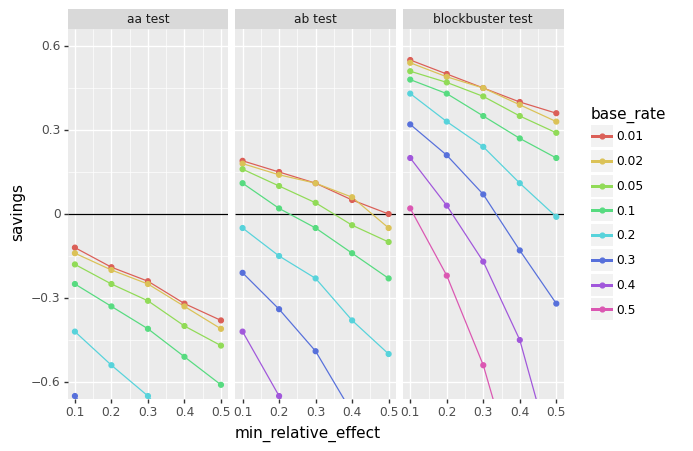

<ggplot: (-9223363308132445436)>

In [10]:
#@title Visualize the Advantage of Sequential A/B Testing
plot_data = (df.assign(base_rate = lambda x: x['base_rate'].astype(str)))
(
    ggplot(data=plot_data, mapping=aes(x='min_relative_effect', y='savings', colour='base_rate'))
    + geom_hline(yintercept=0)
    + geom_line()
    + geom_point()
    + facet_wrap('~ test_type') 
    + coord_cartesian(ylim=(-0.6, 0.6))
)

## 以「1.5 * 基礎轉換率 + 相對差異 < 36%」的經驗法則，確認是否適合用 Sequential A/B Testing
#### 經驗法則視覺化：只有在灰色虛線左邊的範圍，Sequential A/B Testing 才有加速實驗完成的優勢

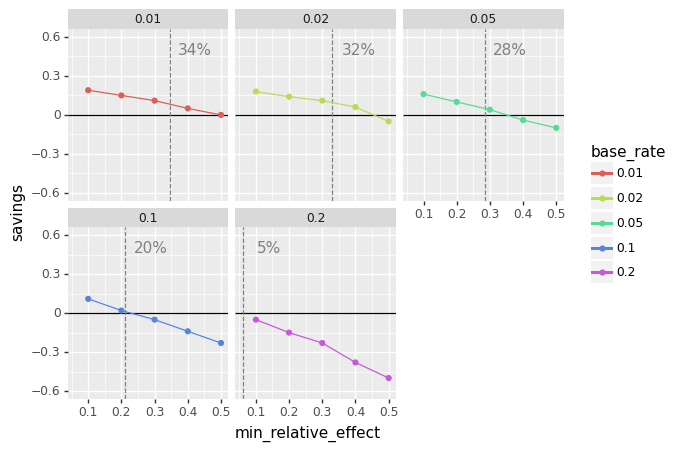

<ggplot: (-9223363308135527964)>

In [11]:
#@title Largest MDE with positive savings
largest_mde = pd.DataFrame({'base_rate': df['base_rate'].unique().astype(str), 
               'largest_mde': 0.36 - 1.5 * df['base_rate'].unique()})
largest_mde = largest_mde.loc[largest_mde['largest_mde'] > 0, :]
plot_data = (df.pipe(lambda x: x.loc[(x['test_type'] == 'ab test') & x['base_rate'].isin(largest_mde['base_rate']), :])
         .assign(base_rate = lambda x: x['base_rate'].astype(str)))
(
    ggplot(data=plot_data, mapping=aes(x='min_relative_effect', y='savings', colour='base_rate'))
    + geom_hline(yintercept=0)
    + geom_vline(data=largest_mde,
           mapping=aes(xintercept='largest_mde'),
           colour='grey',
           linetype='dashed')
    + geom_text(data=largest_mde.assign(largest_mde = (largest_mde['largest_mde']+0.08).round(2),
                       largest_mde_label = (largest_mde['largest_mde'] * 100).astype(int).astype(str) + '%'),
            mapping=aes(x='largest_mde',
                  y=0.5,
                  label='largest_mde_label'),
           colour='grey')
    + geom_line()
    + geom_point()
    + facet_wrap('~ base_rate') 
    + coord_cartesian(ylim=(-0.6, 0.6))
)